In [51]:
import numpy as np 
%pip install plotly==5.8.0
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import seaborn as sb
import statsmodels.api as sm
import plotly.express as px
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%pip install kaleido
import kaleido
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
%pip install -U yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from collections import Counter
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import metrics
from sklearn.metrics import r2_score,silhouette_score,confusion_matrix,accuracy_score
pd.set_option("display.precision",3)
np.set_printoptions(precision=5, suppress=True)
pd.options.display.float_format = '{:.4f}'.format
import plotly.io as pio

pio.renderers.default = "svg"

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


## Read the data

In [52]:
df = pd.read_csv('EV_Type_Properties.csv')
df['inr(10e3)'] = df['PriceEuro']*0.08320
df['RapidCharge'].replace(to_replace=['No','Yes'],value=[0, 1],inplace=True)
df.head()

,Sr,BodyStyle,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,Segment,Seats,PriceEuro,inr(10e3)
0,1.0000,Sedan,Tesla,Model 3 Long Range Dual Motor,4.6000,233,450,161,940,1,AWD,Type 2 CCS,D,5,55480,4615.9360
1,2.0000,Hatchback,Volkswagen,ID.3 Pure,10.0000,160,270,167,250,0,RWD,Type 2 CCS,C,5,30000,2496.0000
2,3.0000,Liftback,Polestar,2,4.7000,210,400,181,620,1,AWD,Type 2 CCS,D,5,56440,4695.8080
3,4.0000,SUV,BMW,iX3,6.8000,180,360,206,560,1,RWD,Type 2 CCS,D,5,68040,5660.9280
4,5.0000,Hatchback,Honda,e,9.5000,145,170,168,190,1,RWD,Type 2 CCS,B,4,32997,2745.3504


## Information of the type of data in seach column

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sr               102 non-null    float64
 1   BodyStyle        103 non-null    object 
 2   Brand            103 non-null    object 
 3   Model            103 non-null    object 
 4   AccelSec         103 non-null    float64
 5   TopSpeed_KmH     103 non-null    int64  
 6   Range_Km         103 non-null    int64  
 7   Efficiency_WhKm  103 non-null    int64  
 8   FastCharge_KmH   103 non-null    int64  
 9   RapidCharge      103 non-null    int64  
 10  PowerTrain       103 non-null    object 
 11  PlugType         103 non-null    object 
 12  Segment          103 non-null    object 
 13  Seats            103 non-null    int64  
 14  PriceEuro        103 non-null    int64  
 15  inr(10e3)        103 non-null    float64
dtypes: float64(3), int64(7), object(6)
memory usage: 13.0+ KB


## Finding out the number of null values

In [54]:
df.isnull().sum()

Sr                 1
BodyStyle          0
Brand              0
Model              0
AccelSec           0
TopSpeed_KmH       0
Range_Km           0
Efficiency_WhKm    0
FastCharge_KmH     0
RapidCharge        0
PowerTrain         0
PlugType           0
Segment            0
Seats              0
PriceEuro          0
inr(10e3)          0
dtype: int64

## Descriptive Statistics of the dataset

In [55]:
df.describe()

,Sr,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,Seats,PriceEuro,inr(10e3)
count,102.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000
mean,51.5000,7.3961,179.1942,338.7864,189.1650,444.2718,0.7476,4.8835,55811.5631,4643.5221
std,29.5888,3.0174,43.5730,126.0144,29.5668,203.9493,0.4365,0.7958,34134.6653,2840.0042
min,1.0000,2.1000,123.0000,95.0000,104.0000,170.0000,0.0000,2.0000,20129.0000,1674.7328
25%,26.2500,5.1000,150.0000,250.0000,168.0000,260.0000,0.5000,5.0000,34429.5000,2864.5344
50%,51.5000,7.3000,160.0000,340.0000,180.0000,440.0000,1.0000,5.0000,45000.0000,3744.0000
75%,76.7500,9.0000,200.0000,400.0000,203.0000,555.0000,1.0000,5.0000,65000.0000,5408.0000
max,102.0000,22.4000,410.0000,970.0000,273.0000,940.0000,1.0000,7.0000,215000.0000,17888.0000


In [56]:
df[(df['Brand'] == 'Tesla ') | (df['Brand'] == 'BMW ')]

,Sr,BodyStyle,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,Segment,Seats,PriceEuro,inr(10e3)
0,1.0000,Sedan,Tesla,Model 3 Long Range Dual Motor,4.6000,233,450,161,940,1,AWD,Type 2 CCS,D,5,55480,4615.9360
3,4.0000,SUV,BMW,iX3,6.8000,180,360,206,560,1,RWD,Type 2 CCS,D,5,68040,5660.9280
8,9.0000,Sedan,Tesla,Model 3 Standard Range Plus,5.6000,225,310,153,650,1,RWD,Type 2 CCS,D,5,46380,3858.8160
13,14.0000,Sedan,BMW,i4,4.0000,200,450,178,650,1,RWD,Type 2 CCS,D,5,65000,5408.0000
21,22.0000,SUV,Tesla,Model Y Long Range Dual Motor,5.1000,217,425,171,930,1,AWD,Type 2 CCS,D,7,58620,4877.1840
24,25.0000,Sedan,Tesla,Model 3 Long Range Performance,3.4000,261,435,167,910,1,AWD,Type 2 CCS,D,5,61480,5115.1360
28,29.0000,Hatchback,BMW,i3 120 Ah,7.3000,150,235,161,270,0,RWD,Type 2 CCS,B,4,38017,3163.0144
33,34.0000,Pickup,Tesla,Cybertruck Tri Motor,3.0000,210,750,267,710,1,AWD,Type 2 CCS,N,6,75000,6240.0000
40,41.0000,Liftback,Tesla,Model S Long Range,3.8000,250,515,184,560,1,AWD,Type 2,F,5,79990,6655.1680
51,52.0000,Cabrio,Tesla,Roadster,2.1000,410,970,206,920,1,AWD,Type 2 CCS,S,4,215000,17888.0000


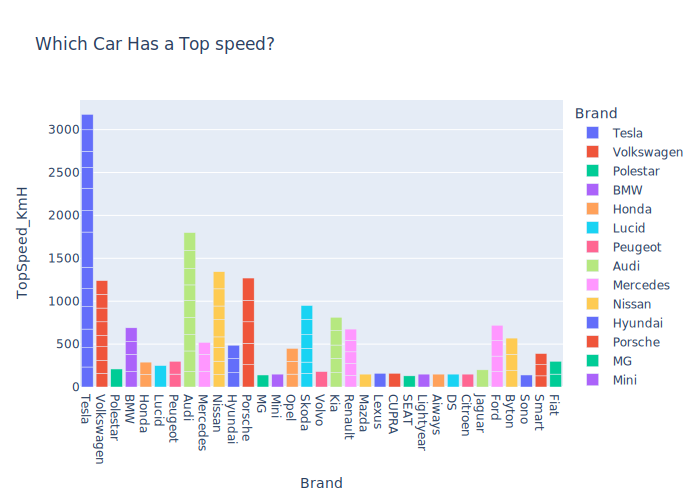

In [57]:
fig = px.bar(df,x='Brand',y = 'TopSpeed_KmH',color = 'Brand',title = 'Which Car Has a Top speed?',labels = {'x':'Car Brands','y':'Top Speed Km/H'})
pio.show(fig)

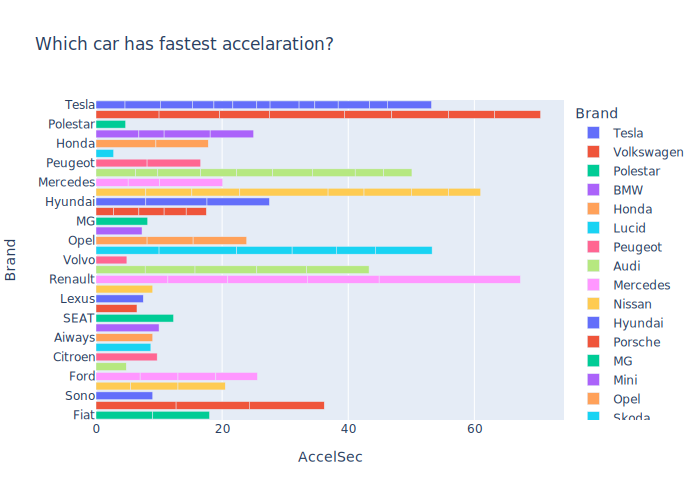

In [58]:
fig = px.bar(df,x='AccelSec',y = 'Brand',color = 'Brand',title = 'Which car has fastest accelaration?',labels = {'x':'Accelaration','y':'Car Brands'})
pio.show(fig)

<Axes: title={'center': 'Car Price'}, xlabel='No. of Samples', ylabel='Car Price'>

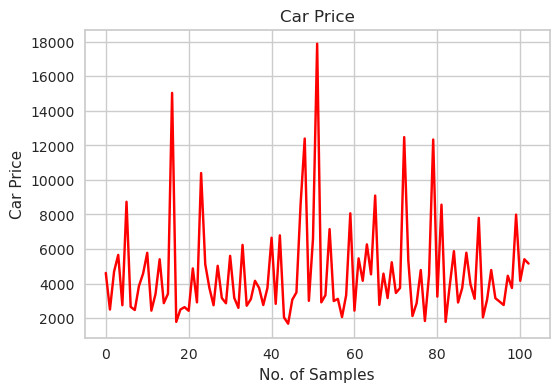

In [59]:
df['inr(10e3)'].plot(figsize = (6,4),title='Car Price',xlabel = 'No. of Samples',ylabel = 'Car Price',color = 'red')

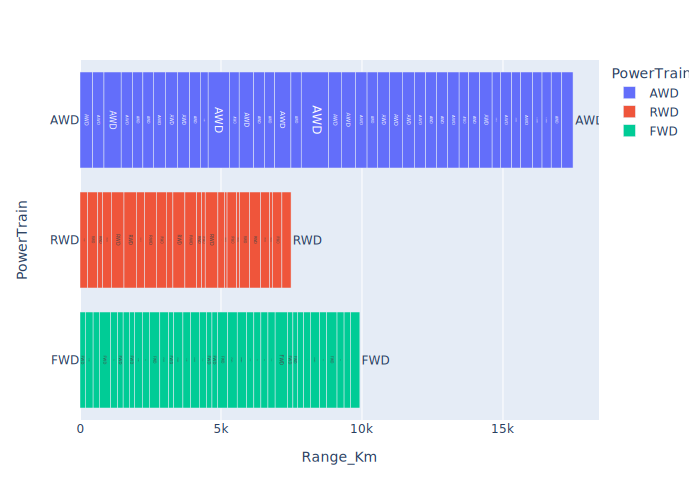

In [60]:
fig = px.bar(df,x = 'Range_Km',y = 'PowerTrain',color = 'PowerTrain',text='PowerTrain')
pio.show(fig)

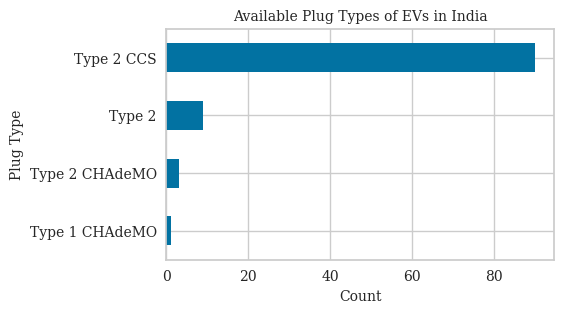

In [61]:
plt.figure(figsize=(5,3))
df['PlugType'].value_counts().sort_values(ascending=True).plot.barh()
plt.xlabel('Count', family='serif', size=10)
plt.ylabel('Plug Type', family='serif', size=10)
plt.xticks(family='serif')
plt.yticks(family='serif')
plt.title('Available Plug Types of EVs in India', family='serif', size=10)
plt.show()

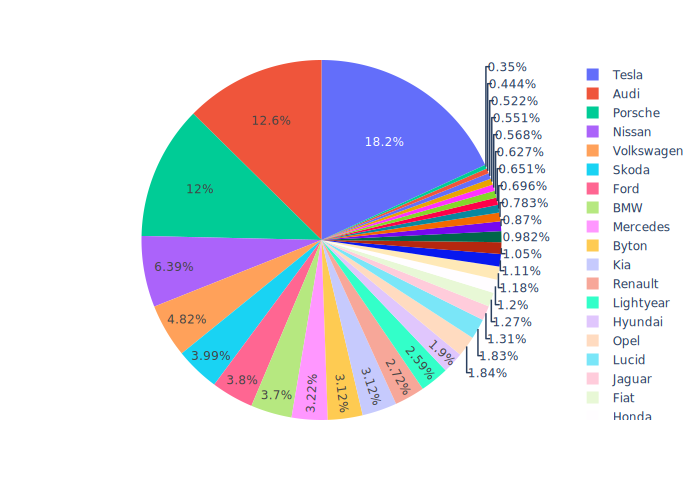

In [62]:
fig = px.pie(df,names = 'Brand',values = 'inr(10e3)')
pio.show(fig)

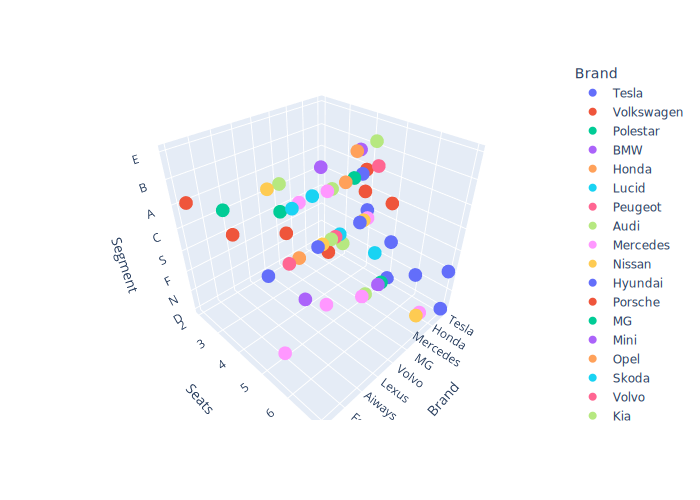

In [63]:
fig = px.scatter_3d(df,x = 'Brand',y = 'Seats',z = 'Segment',color='Brand')
pio.show(fig)

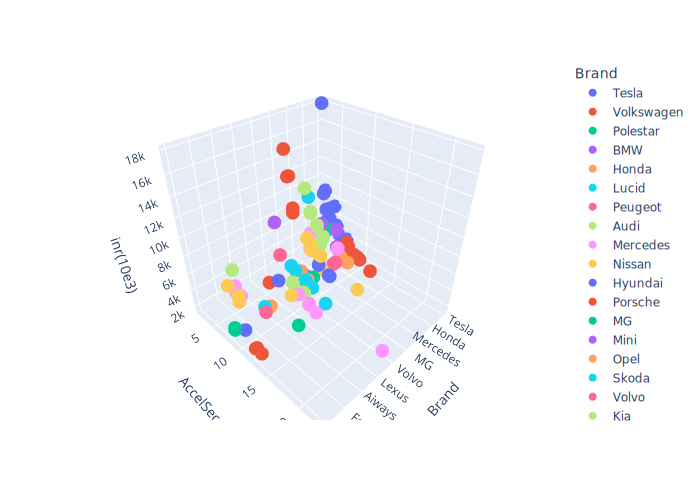

In [64]:
fig = px.scatter_3d(df,x = 'Brand',y = 'AccelSec',z = 'inr(10e3)',color = 'Brand')
pio.show(fig)

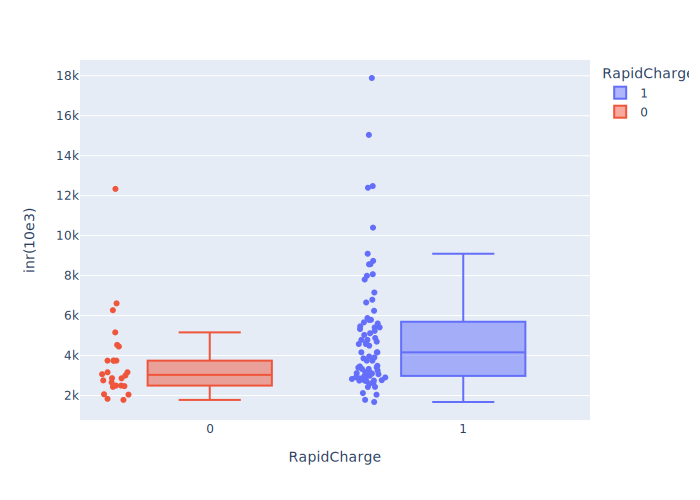

In [65]:
fig = px.box(df,x='RapidCharge',y = 'inr(10e3)',color = 'RapidCharge',points='all')
pio.show(fig)

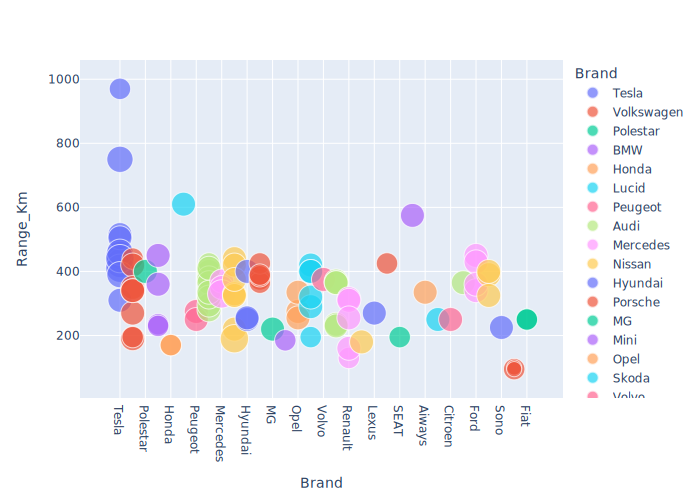

In [66]:
fig = px.scatter(df,x = 'Brand',y = 'Range_Km',size='Seats',color = 'Brand',hover_data=['RapidCharge','inr(10e3)'])
pio.show(fig)

## Pairplot of all the columns based on Rapid Charger presence

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



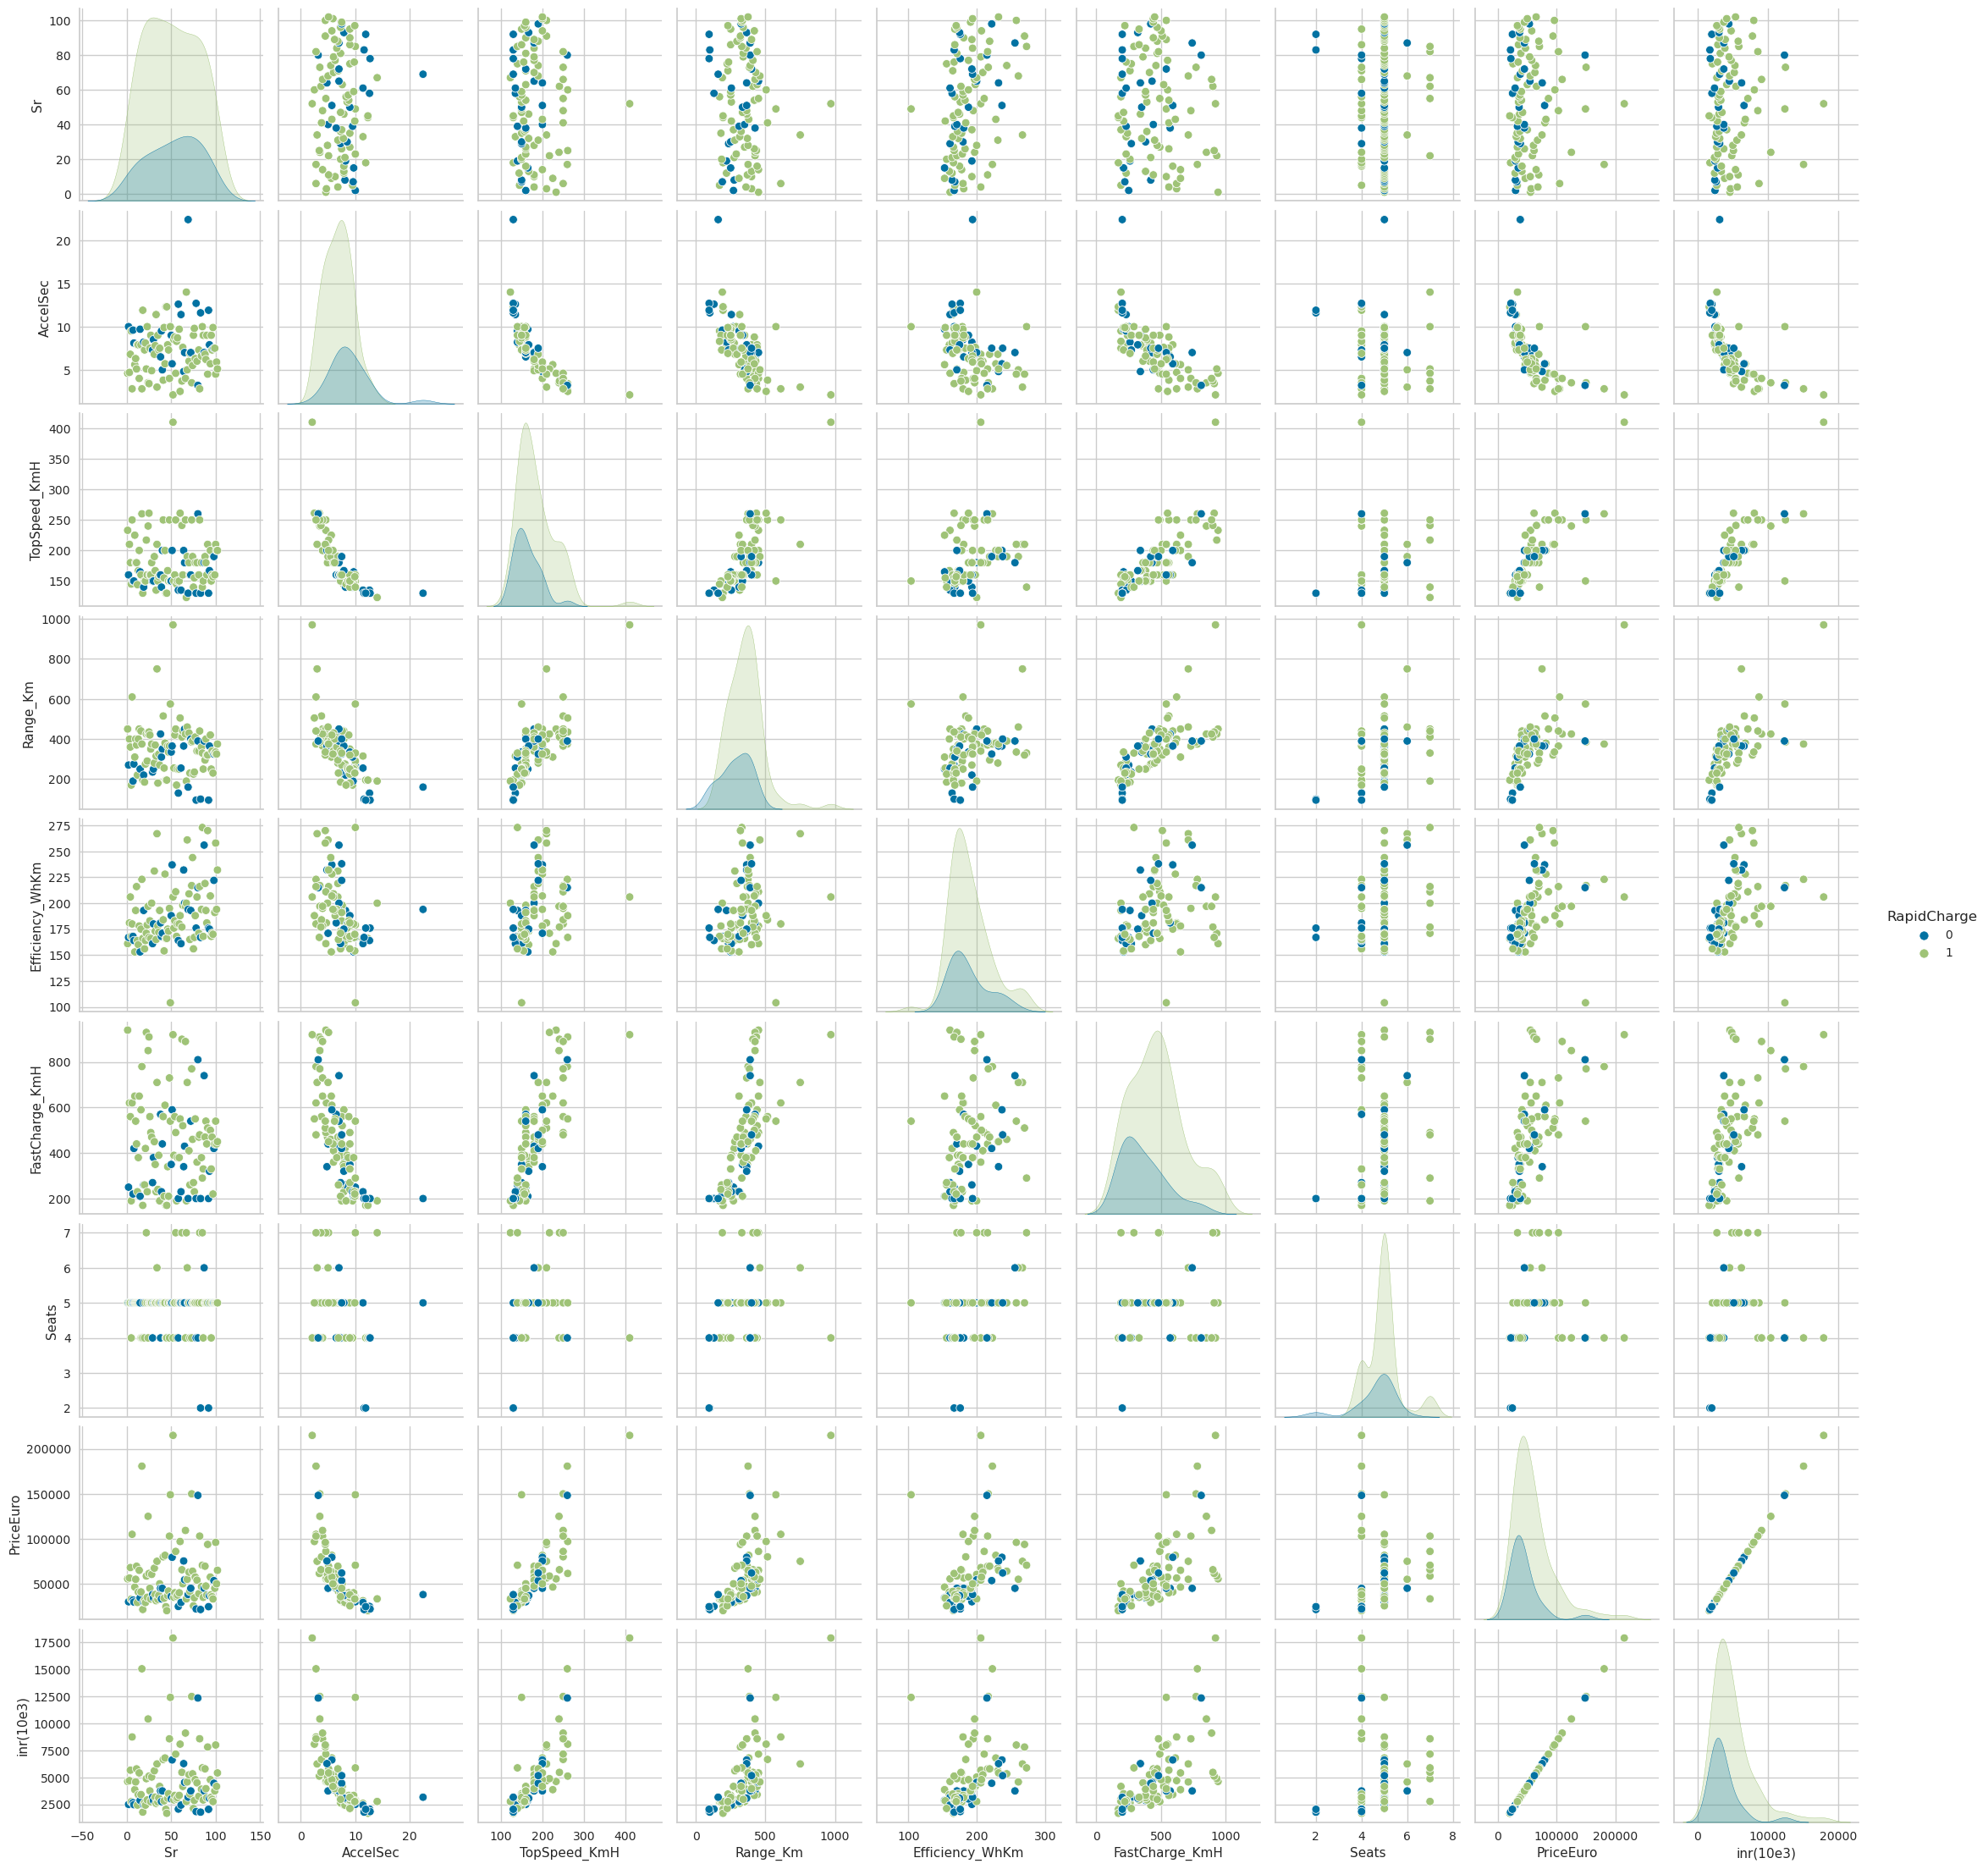

In [67]:
sb.pairplot(df,hue='RapidCharge')

## Heatmap to show the correlation of the data

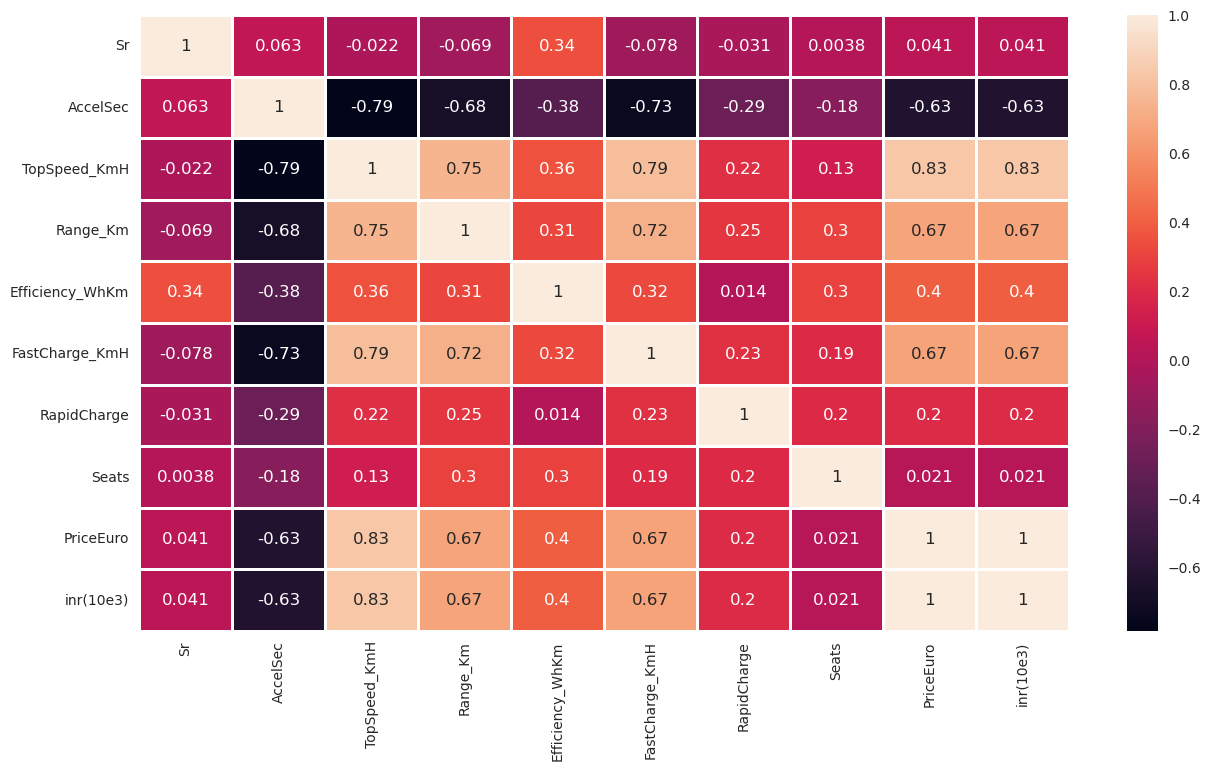

In [68]:
ax= plt.figure(figsize=(15,8))
sb.heatmap(df.corr(numeric_only=True),linewidths=1,linecolor='white',annot=True)

a=np.arange(1,104)

In [69]:
## With a large area of market the cost is dependent on Top speeds and Maximum range of cars. 

# Making Some Comparisions for our dataset


## Frequency of the Brands in the dataset

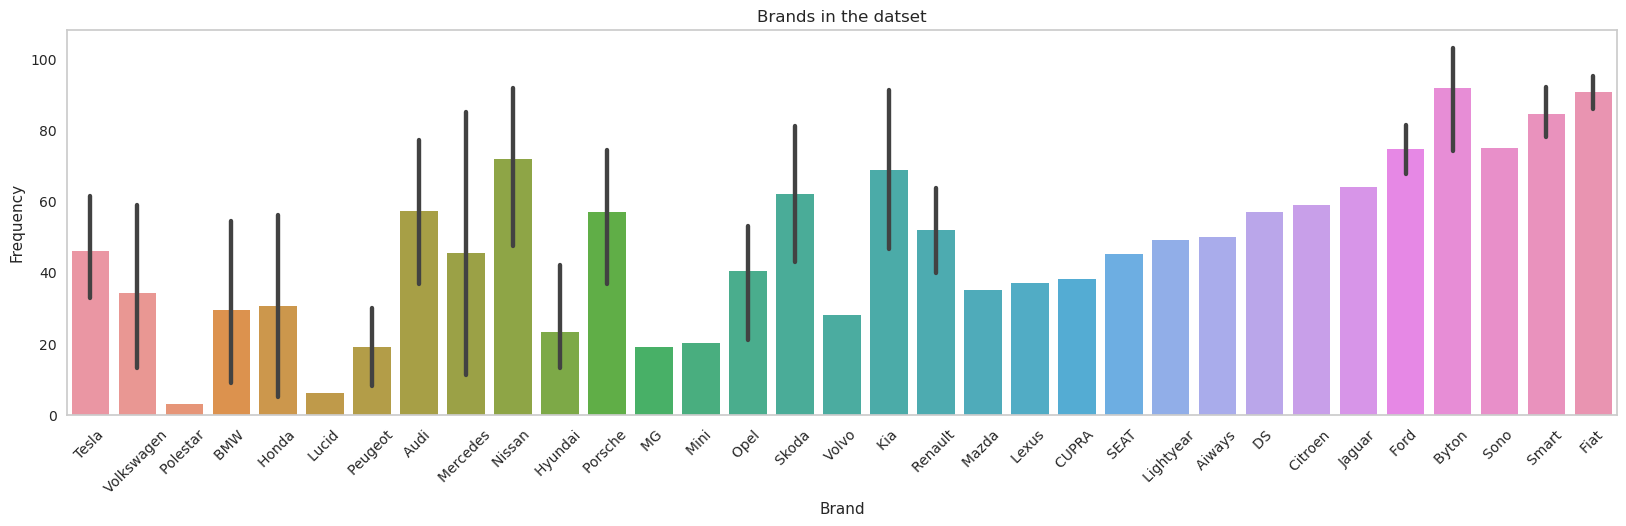

In [70]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y=a,data=df)
plt.grid(axis='y')
plt.title('Brands in the datset')
plt.xlabel('Brand')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## Top speeds achieved by the cars of a brand

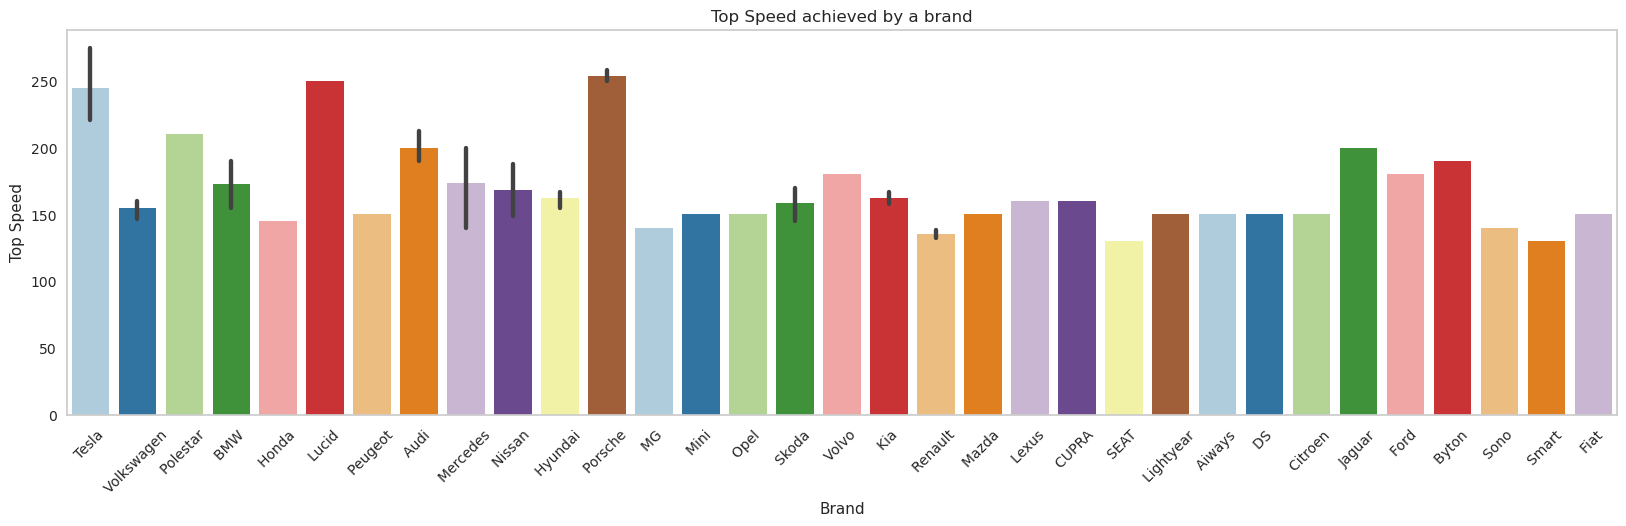

In [71]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='TopSpeed_KmH',data=df,palette='Paired')
plt.grid(axis='y')
plt.title('Top Speed achieved by a brand')
plt.xlabel('Brand')
plt.ylabel('Top Speed')
plt.xticks(rotation=45)
plt.show()

Porsche, Lucid and Tesla produce the fastest cars and Smart the lowest


## Range a car can achieve

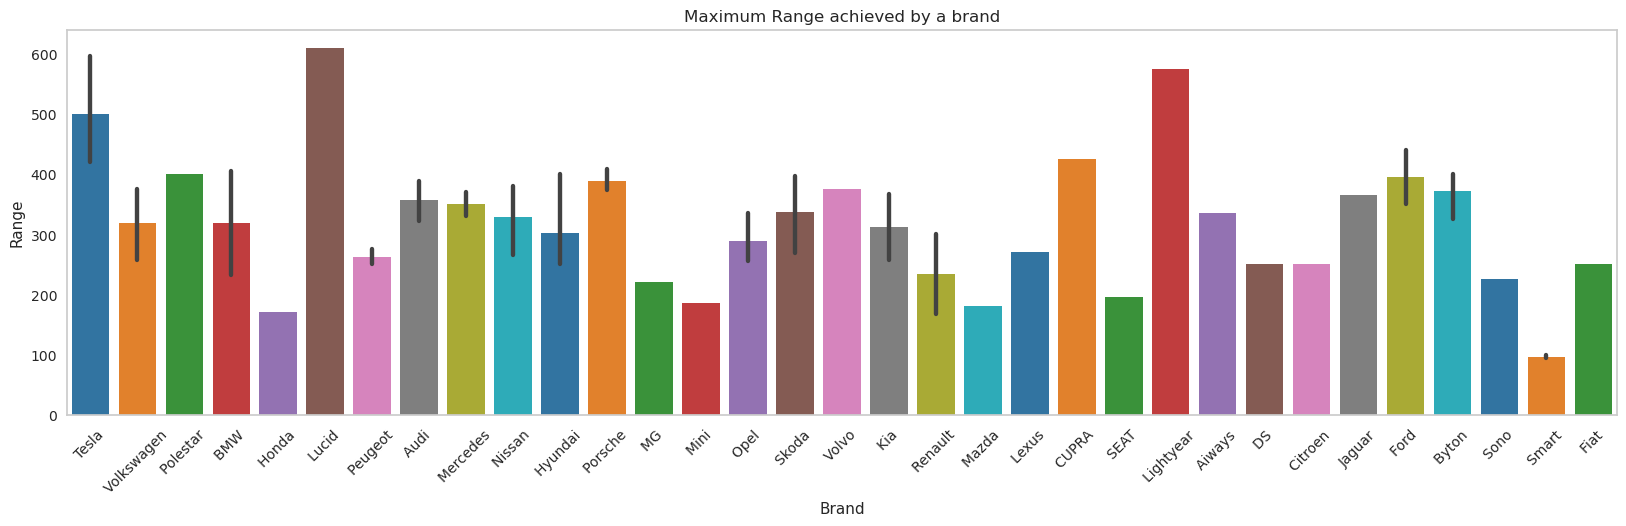

In [72]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='Range_Km',data=df,palette='tab10')
plt.grid(axis='y')
plt.title('Maximum Range achieved by a brand')
plt.xlabel('Brand')
plt.ylabel('Range')
plt.xticks(rotation=45)
plt.show()

Lucid, Lightyear and Tesla have the highest range and Smart the lowest

## Car efficiency

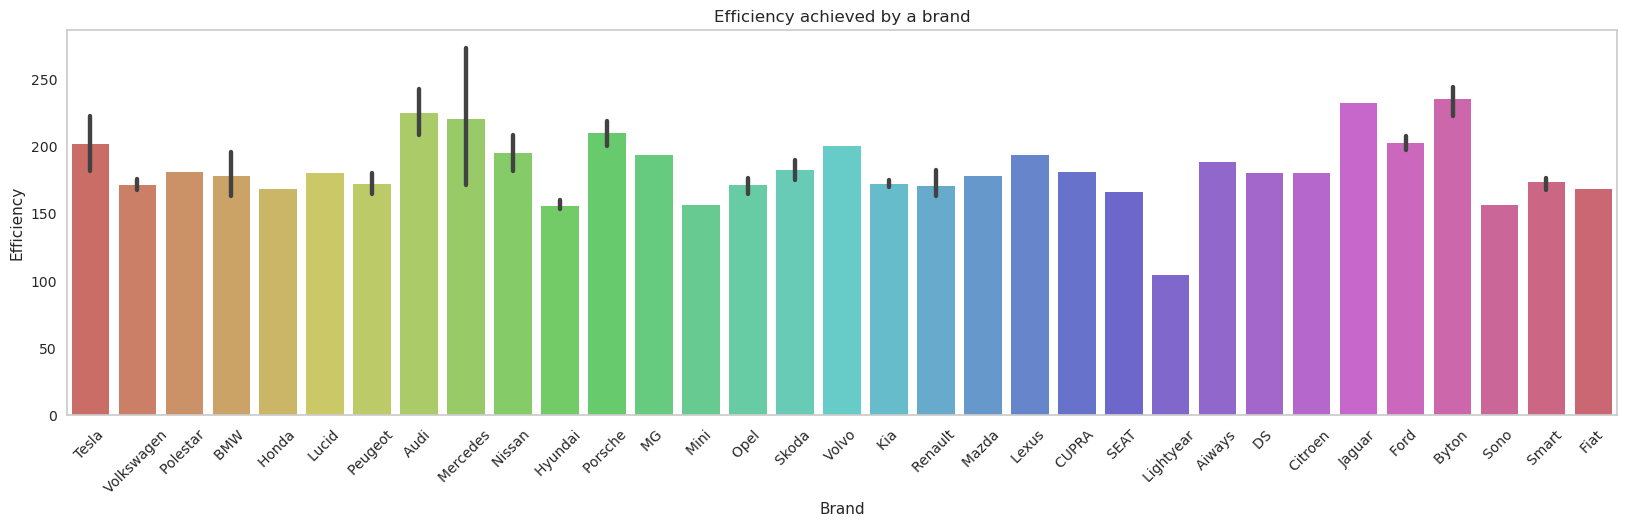

In [73]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='Efficiency_WhKm',data=df,palette='hls')
plt.grid(axis='y')
plt.title('Efficiency achieved by a brand')
plt.xlabel('Brand')
plt.ylabel('Efficiency')
plt.xticks(rotation=45)
plt.show()

Byton , Jaguar and Audi are the most efficient and Lightyear the least

## Number of seats in each car

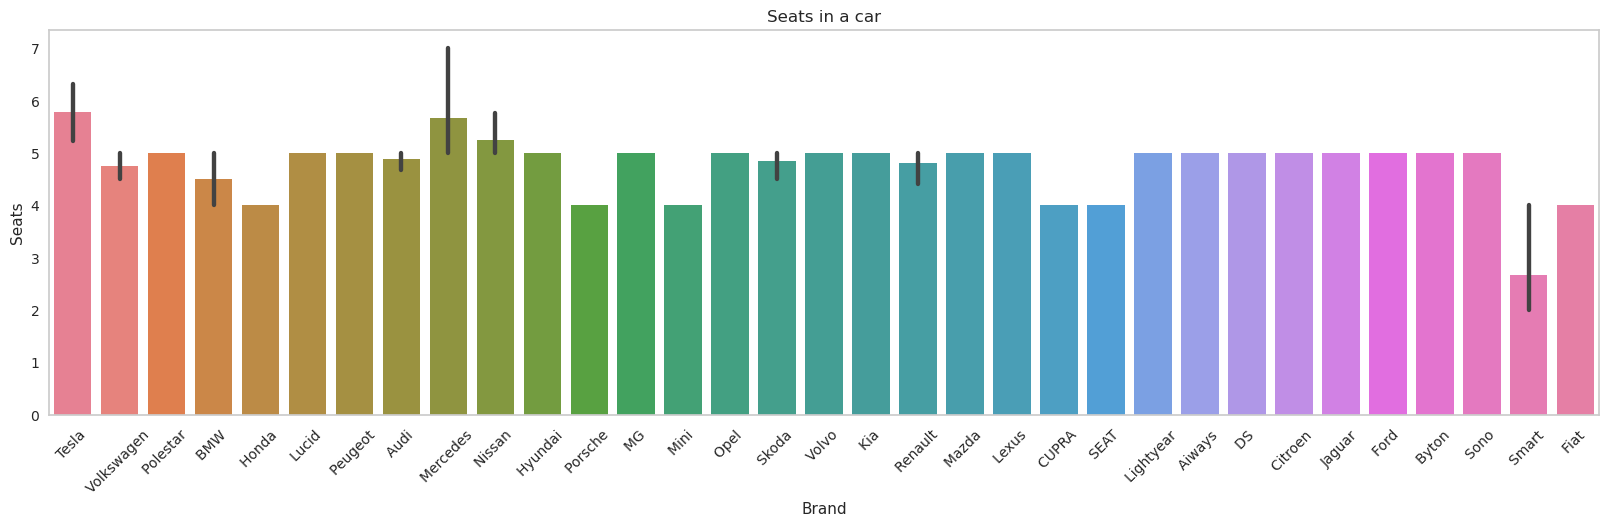

In [74]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='Seats',data=df,palette='husl')
plt.grid(axis='y')
plt.title('Seats in a car')
plt.xlabel('Brand')
plt.ylabel('Seats')
plt.xticks(rotation=45)
plt.show()

Mercedes, Tesla and Nissan have the highest number of seats and Smart the lowest

## Price of cars (in INR)

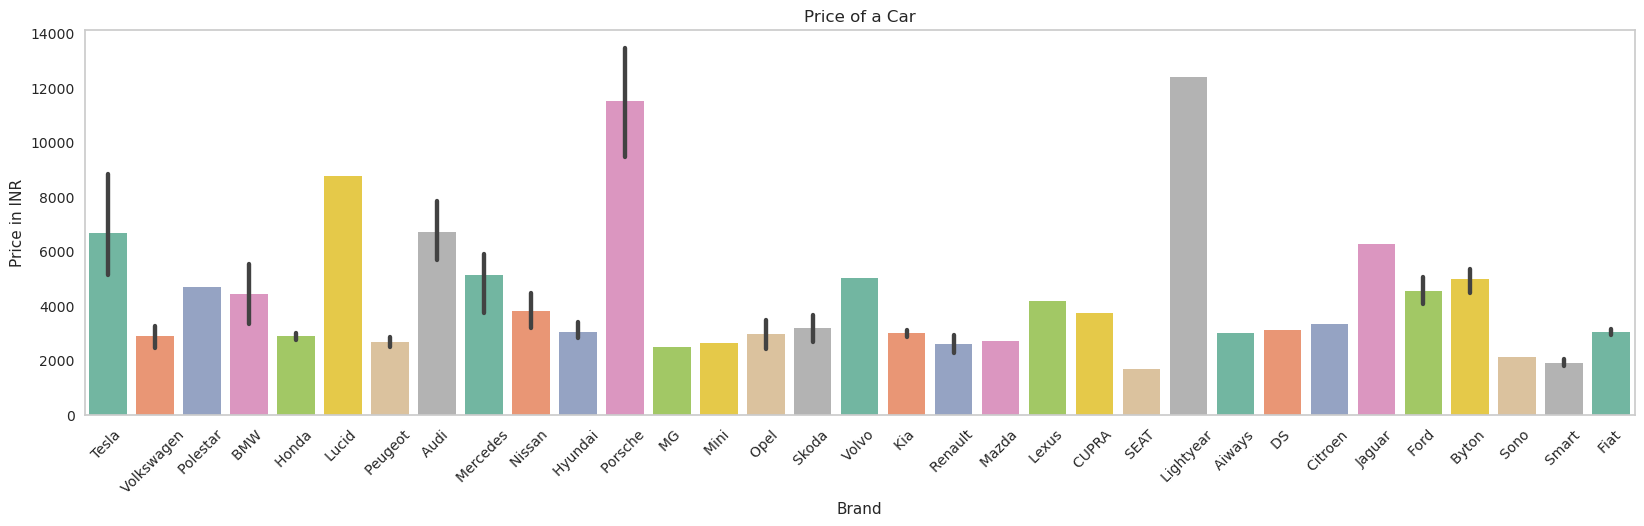

In [133]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='inr(10e3)',data=df,palette='Set2')
plt.title('Price of a Car')
plt.xlabel('Brand')
plt.grid(axis='y')
plt.ylabel('Price in INR')
plt.xticks(rotation=45)
plt.show()

Lightyear, Porsche and Lucid are the most expensive and SEAT and Smart the least

## Type of Plug used for charging

Text(0.5, 1.0, 'Plug Type')

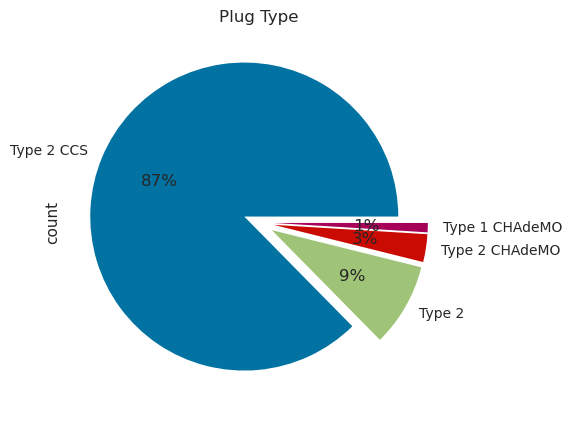

In [76]:
df['PlugType'].value_counts().plot.pie(figsize=(8,5),autopct='%.0f%%',explode=(.1,.1,.1,.1))
plt.title('Plug Type')

Most companies use Type 2 CCS and Type 1 CHAdeMo the least

## Cars and their body style

Text(0.5, 1.0, 'Body Style')

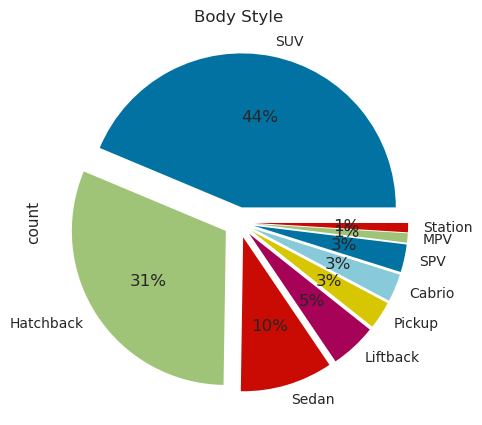

In [77]:
df['BodyStyle'].value_counts().plot.pie(figsize=(8,5),autopct='%.0f%%',explode=(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1))
plt.title('Body Style')

Most cars are either SUV or Hatchback

## Segment in which the cars fall under

Text(0.5, 1.0, 'Segment')

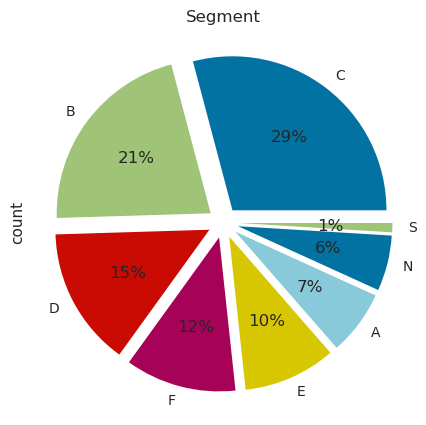

In [78]:
df['Segment'].value_counts().plot.pie(figsize=(8,5),autopct='%.0f%%',explode=(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1))
plt.title('Segment')

Most cars are either C or B type

## Number of Seats

Text(0.5, 1.0, 'Seats')

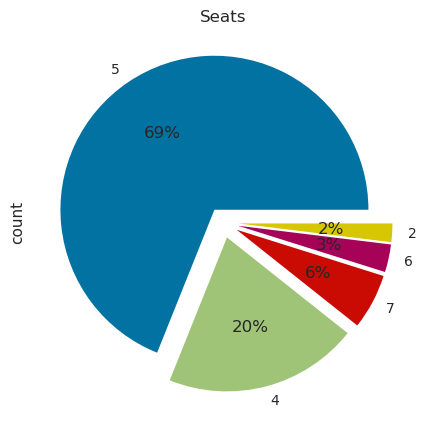

In [79]:
df['Seats'].value_counts().plot.pie(figsize=(8,5),autopct='%.0f%%',explode=(0.1,0.1,0.1,0.1,0.1))
plt.title('Seats')

Majority of cars have 5 seats

## Model with Top Speed¶

In [80]:
speed_df = df.sort_values(by=['TopSpeed_KmH'], ascending=False)
speed_df[['Brand','Model','TopSpeed_KmH']].head(n=1)

,Brand,Model,TopSpeed_KmH
51,Tesla,Roadster,410


In [81]:
df3= df[["TopSpeed_KmH", "inr(10e3)"]].groupby("TopSpeed_KmH").count()
df4= df[["Range_Km", "inr(10e3)"]].groupby("Range_Km").count()
df5= df[["Range_Km", "TopSpeed_KmH"]].groupby("Range_Km").count()
df3=df3.sort_values("TopSpeed_KmH",ascending = False).head(10)
df4=df4.sort_values("Range_Km",ascending = False).head(10)
df5=df5.sort_values("Range_Km",ascending = False).head(10)

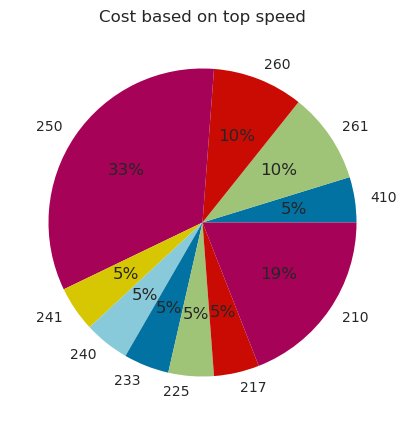

In [82]:
plt.figure(figsize=(8,5))
plt.title('Cost based on top speed')
plt.pie(x=df3["inr(10e3)"],labels=df3.index,autopct='%1.0f%%')
plt.show()

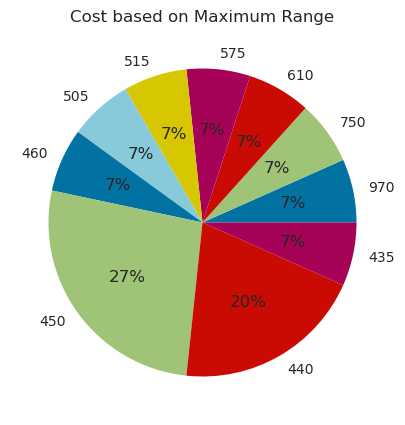

In [83]:
plt.figure(figsize=(8,5))
plt.title('Cost based on Maximum Range')
plt.pie(x=df4["inr(10e3)"],labels=df4.index,autopct='%1.0f%%')
plt.show()

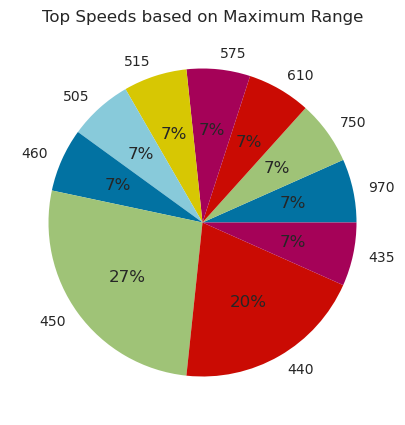

In [84]:
plt.figure(figsize=(8,5))
plt.title('Top Speeds based on Maximum Range')
plt.pie(x=df5["TopSpeed_KmH"],labels=df5.index,autopct='%1.0f%%')
plt.show()

## Model Building Using K-Means Clusteing

In [85]:
# encoding the categorical features

# PowerTrain feature
df['PowerTrain'].replace(to_replace=['RWD','FWD','AWD'],value=[0, 1, 2],inplace=True)

# RapidCharge feature
df['RapidCharge'].replace(to_replace=['No','Yes'],value=[0, 1],inplace=True)

In [86]:
# selecting features for building a model
X = df[['AccelSec','TopSpeed_KmH','Efficiency_WhKm','FastCharge_KmH', 'Range_Km', 'RapidCharge', 'Seats', 'PriceEuro','PowerTrain']]

In [87]:
# feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [88]:
# applying Principle Component Analysis (PCA)
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,2.4292,-0.5546,-1.1478,-0.8828,0.8400,-0.9593,0.9989,0.7111,-0.3967
1,-2.3225,-0.3454,0.8965,-1.3055,0.0796,0.2351,-0.2137,-0.5441,-0.1819
2,1.5879,0.0089,-0.6505,0.0410,0.5935,-0.6982,0.0587,0.2488,-0.2028
3,0.2910,-0.0001,-0.3077,-0.5142,-1.6089,0.2916,0.3650,-0.2355,0.2617
4,-2.6027,-0.6265,-0.8881,0.5853,-0.8021,0.0274,-0.0850,-0.5078,-0.0499


In [89]:
df_pca=df_pca.iloc[:,:9]
df_pca.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,2.4292,-0.5546,-1.1478,-0.8828,0.8400,-0.9593,0.9989,0.7111,-0.3967
1,-2.3225,-0.3454,0.8965,-1.3055,0.0796,0.2351,-0.2137,-0.5441,-0.1819
2,1.5879,0.0089,-0.6505,0.0410,0.5935,-0.6982,0.0587,0.2488,-0.2028


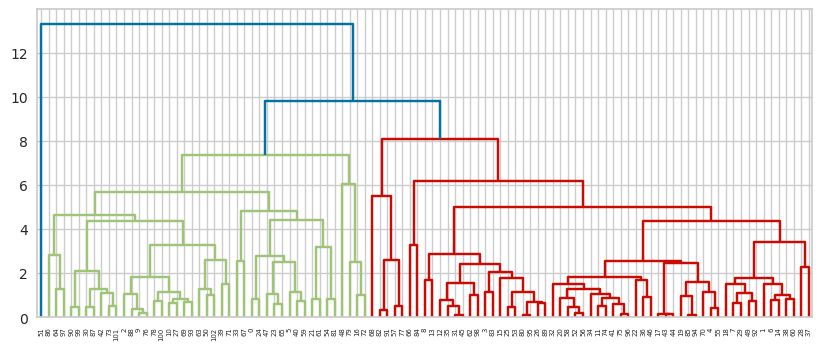

In [90]:
# Dendrogram
linked = linkage(df_pca, 'complete')
plt.figure(figsize=(10, 4))
dendrogram(linked, orientation='top')
plt.show()

In [91]:
wcss = []

for i in range(1, 11):
  kmean = KMeans(n_clusters=i, init='k-means++', random_state=90)
  kmean.fit(X_pca)
  wcss.append(kmean.inertia_)

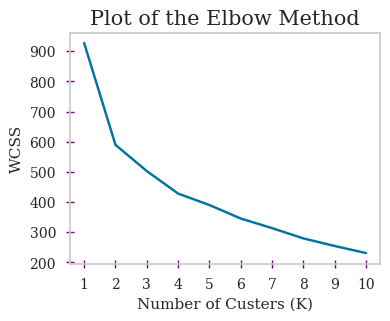

In [92]:
# plotting the results of Elbow

plt.figure(figsize=(4,3))
plt.title('Plot of the Elbow Method', size=15, family='serif')
plt.plot(range(1, 11), wcss)
plt.xticks(range(1, 11), family='serif')
plt.yticks(family='serif')
plt.xlabel('Number of Custers (K)', family='serif')
plt.ylabel('WCSS', family='serif')
plt.grid()
plt.tick_params(axis='both', direction='inout', length=6, color='purple', grid_color='lightgray', grid_linestyle='--')
plt.show()

## Clustering

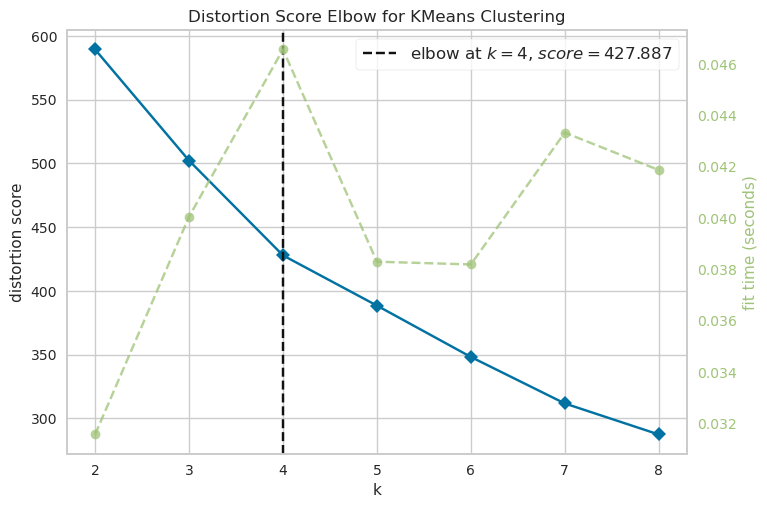

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [93]:
model = KMeans(random_state=40)
visualizer = KElbowVisualizer(model, k=(2,9), metric='distortion', timings=True)
visualizer.fit(X_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

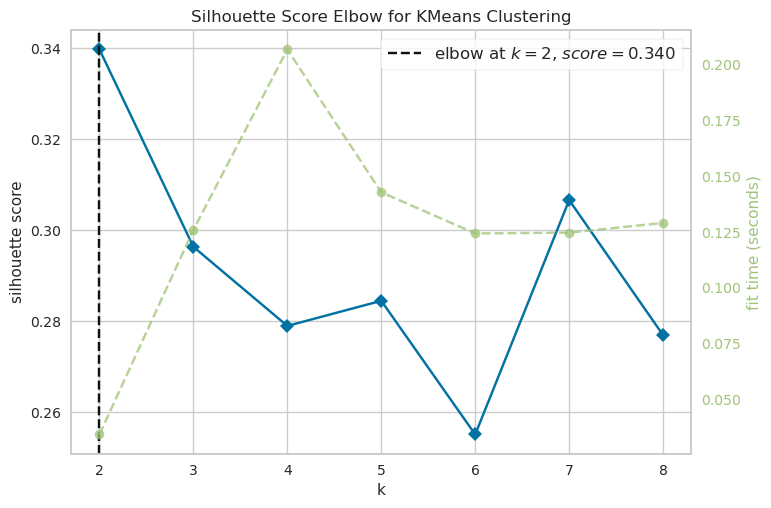

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [94]:
model = KMeans(random_state=40)
visualizer = KElbowVisualizer(model, k=(2,9), metric='silhouette', timings=True)
visualizer.fit(X_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

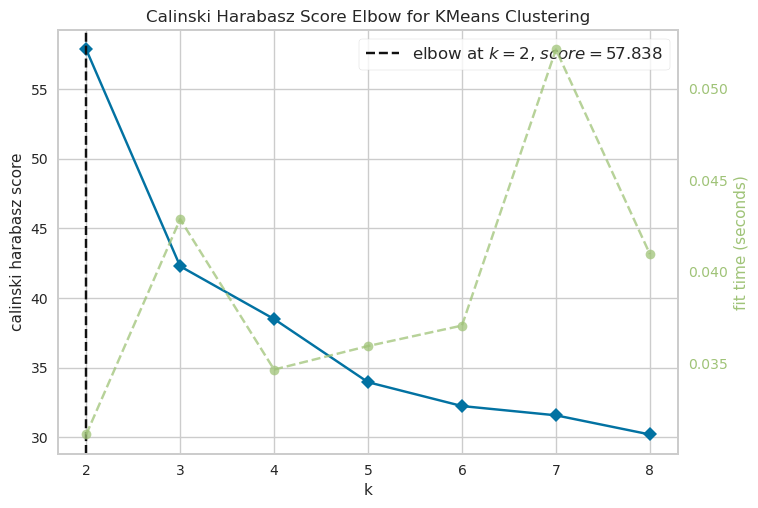

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [95]:
model = KMeans(random_state=40)
visualizer = KElbowVisualizer(model, k=(2,9), metric='calinski_harabasz', timings=True)
visualizer.fit(X_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [108]:
kmean = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(X_pca)
df['cluster_num'] = kmean.labels_ #adding to df

<Axes: xlabel='TopSpeed_KmH', ylabel='FastCharge_KmH'>

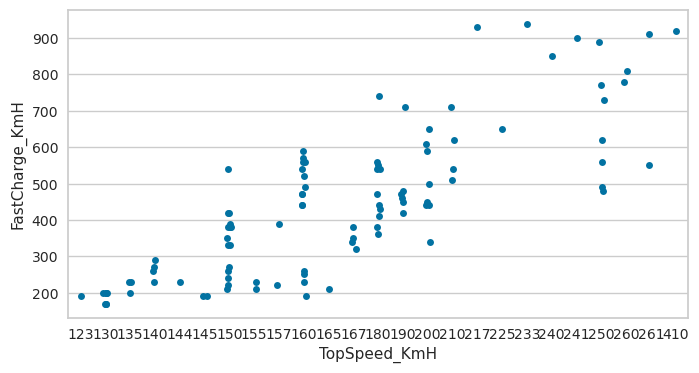

In [109]:
#Visulazing clusters
ax=plt.subplots(figsize=(8,4))
sb.stripplot(x='TopSpeed_KmH', y='FastCharge_KmH', data=df, jitter=True)

<Axes: xlabel='TopSpeed_KmH', ylabel='Efficiency_WhKm'>

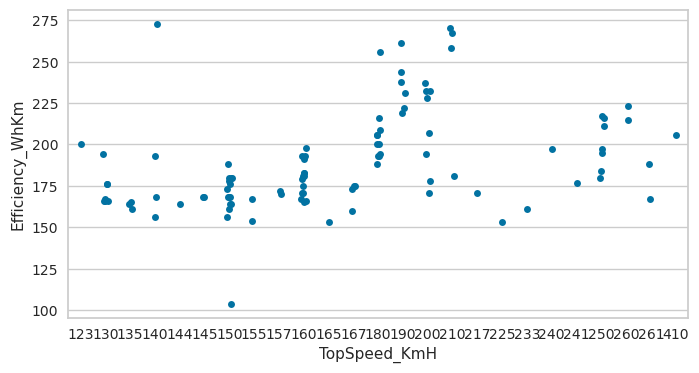

In [110]:
ax=plt.subplots(figsize=(8,4))
sb.stripplot(x='TopSpeed_KmH', y='Efficiency_WhKm', data=df, jitter=True)

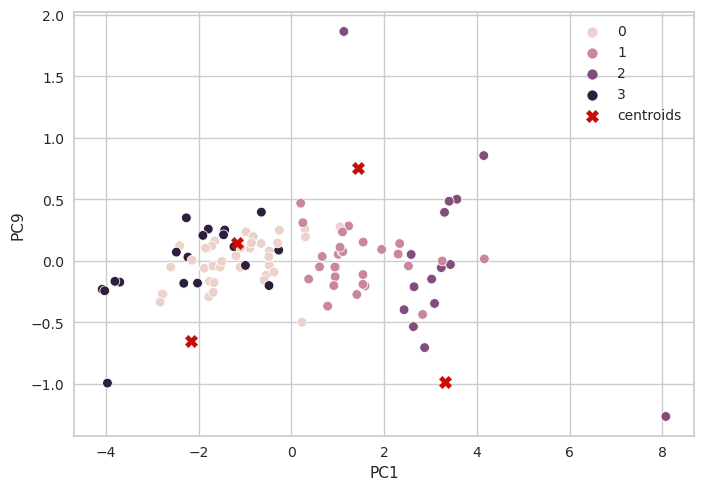

In [111]:
#Visulazing clusters
sb.scatterplot(data=df_pca, x="PC1", y="PC9", hue=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0], kmean.cluster_centers_[:,1], 
            marker="X", c="r", s=80, label="centroids")
plt.legend()
plt.show()

## Regression for data2

In [112]:
X=df_pca[['PC1', 'PC2','PC3','PC4','PC5','PC6', 'PC7','PC8','PC9']]
y=df['inr(10e3)']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.4, random_state=101)
lm=LinearRegression().fit(X_train,y_train)

In [114]:
print(lm.intercept_)

4643.522050485438


In [115]:
lm.coef_

array([ 1101.58721,  -741.20904,   208.53617,   508.32246,   122.3533 ,
        1579.00686,   333.61147, -1079.99512,  1461.72269])

In [116]:
X_train.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'], dtype='object')

In [117]:
cdf=pd.DataFrame(lm.coef_, X.columns, columns=['Coeff'])
cdf

,Coeff
PC1,1101.5872
PC2,-741.2090
PC3,208.5362
PC4,508.3225
PC5,122.3533
PC6,1579.0069
PC7,333.6115
PC8,-1079.9951
PC9,1461.7227


In [118]:
predictions=lm.predict(X_test)
predictions

array([ 3744.    ,  2496.    ,  5233.28  ,  3243.7184,  3064.8384,
        5459.584 ,  2903.68  ,  3328.    ,  3952.    ,  2594.5088,
        2654.08  ,  3744.    ,  2041.2288, 15040.9792,  6609.824 ,
        3170.336 ,  4451.2   ,  2866.9888,  3744.    , 17888.    ,
        4877.184 ,  5660.928 ,  5876.4992,  2062.528 , 12396.8   ,
        8565.024 , 12338.6432,  3328.    ,  4695.808 ,  5408.    ,
        3064.8384,  3120.    ,  2826.3872, 10400.    ,  2745.6   ,
        2912.    ,  3153.28  ,  5028.3584,  2424.9472,  2766.0672,
        5604.1856,  3098.1184])

In [119]:
y_test

37    3744.0000
1     2496.0000
69    5233.2800
80    3243.7184
92    3064.8384
61    5459.5840
85    2903.6800
53    3328.0000
88    3952.0000
32    2594.5088
6     2654.0800
71    3744.0000
43    2041.2288
16   15040.9792
50    6609.8240
31    3170.3360
97    4451.2000
14    2866.9888
25    3744.0000
51   17888.0000
21    4877.1840
3     5660.9280
84    5876.4992
57    2062.5280
48   12396.8000
47    8565.0240
79   12338.6432
58    3328.0000
2     4695.8080
13    5408.0000
45    3064.8384
89    3120.0000
41    2826.3872
23   10400.0000
26    2745.6000
22    2912.0000
94    3153.2800
27    5028.3584
20    2424.9472
66    2766.0672
30    5604.1856
35    3098.1184
Name: inr(10e3), dtype: float64

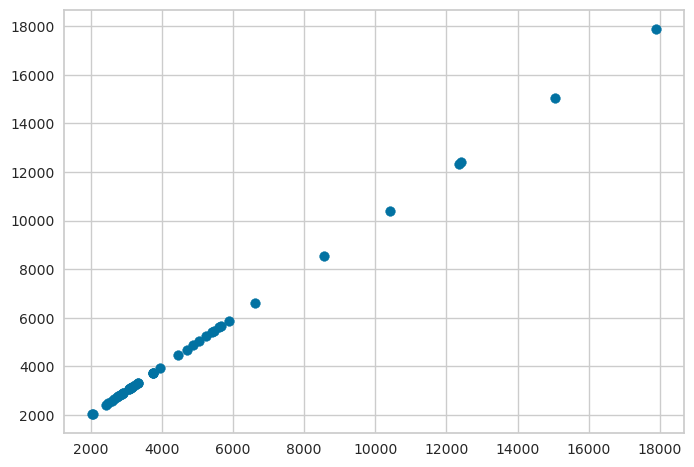

In [120]:
plt.scatter(y_test, predictions)

<Axes: xlabel='inr(10e3)', ylabel='Count'>

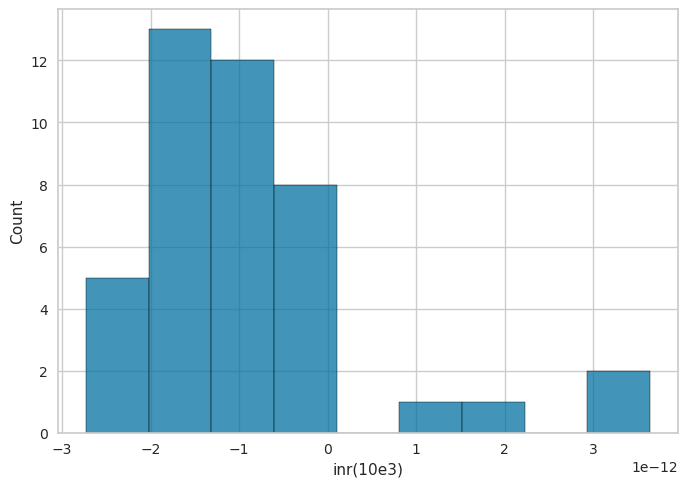

In [121]:
#Residual histogram plot
sb.histplot((y_test-predictions))

In [122]:
print('MAE:',metrics.mean_absolute_error(y_test,predictions))
print('MSE:',metrics.mean_squared_error(y_test,predictions))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,predictions)))

MAE: 1.3209327811463957e-12
MSE: 2.589863108350551e-24
RMSE: 1.609305163215029e-12


In [123]:
metrics.mean_absolute_error(y_test,predictions)

1.3209327811463957e-12

In [124]:
metrics.mean_squared_error(y_test,predictions)

2.589863108350551e-24

In [125]:
np.sqrt(metrics.mean_squared_error(y_test,predictions))

1.609305163215029e-12

In [126]:
##Geographic Data##

In [127]:
evgeo = pd.read_csv('EV_Category_Geographic_1.csv')
newev_geo= evgeo.drop(32, axis='rows')
newev_geo

,State Name,Two Wheeler,Three Wheeler,Four Wheeler,Goods Vehicles,Public Service Vehicle,Special Category Vehicles,Ambulance/Hearses,Construction Equipment Vehicle,Other,Grand Total
0,Andaman and Nicobar Island,1,30.0000,81,NaN,40.0000,NaN,NaN,NaN,7.0000,159
1,Arunachal Pradesh,14,NaN,5,NaN,NaN,NaN,NaN,NaN,1.0000,20
2,Assam,721,47041.0000,161,7.0000,15.0000,NaN,NaN,NaN,2.0000,47947
3,Bihar,5003,59079.0000,114,11.0000,26.0000,NaN,NaN,NaN,8.0000,64241
4,Chandigarh,298,1410.0000,182,NaN,40.0000,NaN,NaN,NaN,1.0000,1931
5,Chhattisgarh,6424,5341.0000,117,1077.0000,1.0000,NaN,NaN,368.0000,100.0000,13428
6,Delhi,14730,112831.0000,3051,49.0000,39.0000,NaN,NaN,NaN,1602.0000,132302
7,Goa,1314,28.0000,289,13.0000,36.0000,2.0000,NaN,NaN,4.0000,1686
8,Gujarat,13662,1869.0000,1309,28.0000,278.0000,344.0000,NaN,26.0000,77.0000,17593
9,Haryana,7777,18595.0000,186,122.0000,8.0000,2.0000,NaN,NaN,90.0000,26780


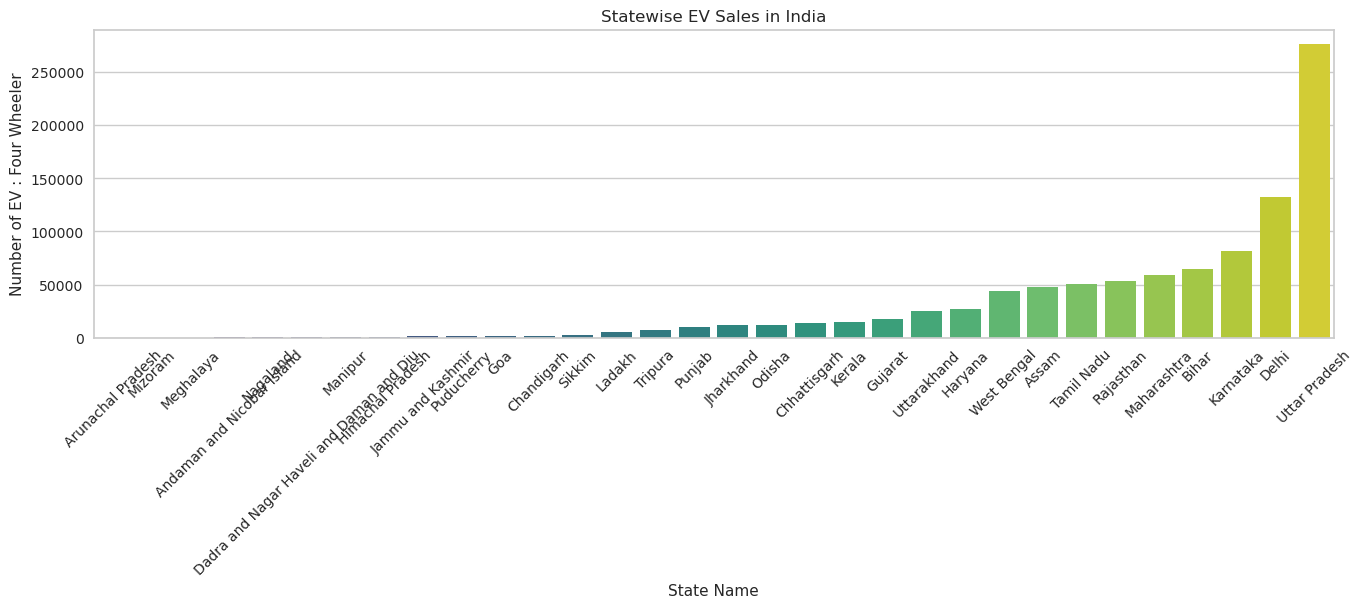

In [128]:
newev_geo=newev_geo.sort_values('Grand Total')
plt.figure(figsize=(16,4))
sb.barplot(x=newev_geo['State Name'], y=newev_geo['Grand Total'], palette="viridis")
plt.title('Statewise EV Sales in India')
plt.xlabel('State Name')
plt.ylabel('Number of EV : Four Wheeler')
plt.xticks(rotation=45)
plt.show()

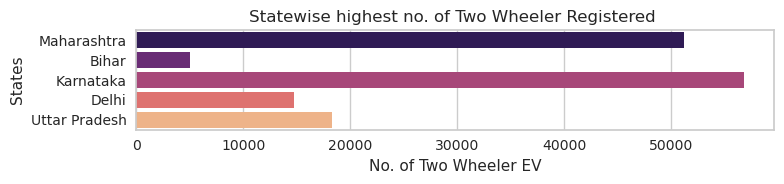

In [129]:
top_count = newev_geo.tail(5)
plt.figure(figsize=(8, 2))
sb.barplot(x='Two Wheeler', y='State Name', data=top_count, palette="magma")
plt.title('Statewise highest no. of Two Wheeler Registered ')
plt.xlabel('No. of Two Wheeler EV')
plt.ylabel('States')
plt.tight_layout()
plt.show()

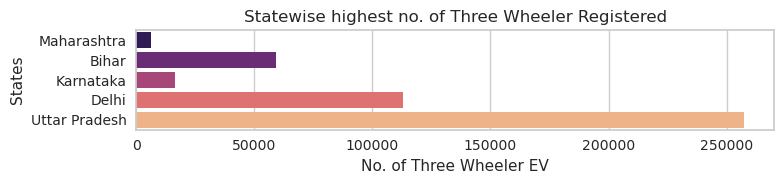

In [130]:
top_count = newev_geo.tail(5)
plt.figure(figsize=(8, 2))
sb.barplot(x='Three Wheeler', y='State Name', data=top_count, palette="magma")
plt.title('Statewise highest no. of Three Wheeler Registered')
plt.xlabel('No. of Three Wheeler EV')
plt.ylabel('States')
plt.tight_layout()
plt.show()

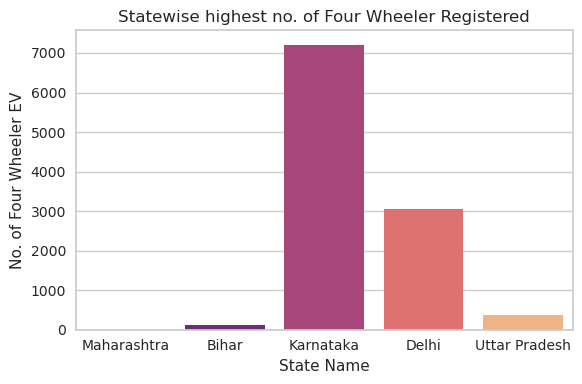

In [131]:
top_count = newev_geo.tail(5)
plt.figure(figsize=(6, 4))
sb.barplot(x='State Name', y='Four Wheeler', data=top_count, palette="magma")
plt.title('Statewise highest no. of Four Wheeler Registered')
plt.xlabel('State Name')
plt.ylabel('No. of Four Wheeler EV')
plt.tight_layout()
plt.show()

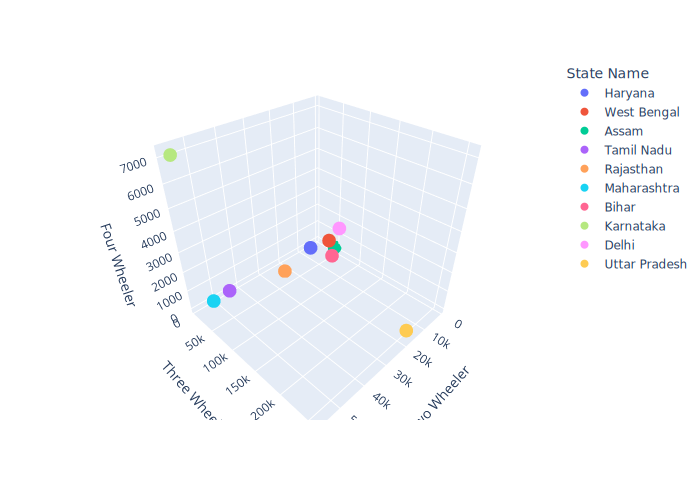

In [132]:
Top_EV_State=newev_geo.tail(10)
Top_EV_State
fig = px.scatter_3d(Top_EV_State,x = 'Two Wheeler',y = 'Three Wheeler',z = 'Four Wheeler',color='State Name')
pio.show(fig)